<h1>Initialize PySpark</h1>

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySpark ML").getOrCreate()


<h1>All necessary imports</h1>


In [2]:
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

<h1>Read the data and split into training and testing sets</h1>

In [3]:
df = spark.read.format("csv").option("header", "false").load("../data/cal_housing.data")
training_df,testing_df = df.randomSplit((0.8,0.2),seed=1234)

<h1>Write the prepareData function</h1>

In [4]:
from pyspark.sql.functions import udf
def prepareData(df):
    df = df.toDF("Longitude","Latitude","MedianAge","TotalRooms","TotalBedrooms","Population","Households",
            "MedianIncome","MedianHomeValue")
    df = df.select(*(col(c).cast("float").alias(c) for c in df.schema.names))
    df = df.withColumn("MedianHomeValue",col("MedianHomeValue")/100000)
    df = df.withColumn("RoomsPerHouse", col("TotalRooms")/col("Households"))\
        .withColumn("PeoplePerHouse", col("Population")/col("Households"))\
       .withColumn("BedroomsPerHouse", col("TotalBedrooms")/col("Households"))
    df_analysis = df.select("MedianHomeValue", 
              "MedianAge", 
              "Population", 
              "Households", 
              "MedianIncome", 
              "RoomsPerHouse", 
              "PeoplePerHouse", 
              "BedroomsPerHouse")
    return df_analysis




<h1>Transform the dependent variable into two buckets</h1>
<li>Use QuantileDiscretizer with two buckets</li>
<li><a href="https://spark.apache.org/docs/latest/ml-features#quantilediscretizer">https://spark.apache.org/docs/latest/ml-features#quantilediscretizer</a></li>


In [5]:

discretizer = QuantileDiscretizer()\
  .setInputCol("MedianHomeValue")\
  .setOutputCol("DVBucket") \
  .setNumBuckets(2)

bucketizer = discretizer.fit(prepareData(df))
bucketed = bucketizer.transform(prepareData(df))
bucketed.where(bucketed["DVBucket"]==0).count()

10296

<h1>Transform independent variable features into a vector</h1>

In [6]:
assembler = VectorAssembler()\
    .setInputCols(("MedianAge","Population", "Households", 
                        "MedianIncome", "RoomsPerHouse", "PeoplePerHouse", "BedroomsPerHouse"))\
    .setOutputCol("features")



<h1>Build two models</h1>
<li>A Logistic Regression Model</li>
<li>A Random Forest Classifier</li>
<li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html">https://spark.apache.org/docs/latest/ml-classification-regression.html</a></li>

In [7]:
rrr = RandomForestClassifier()\
    .setFeaturesCol("features")\
    .setLabelCol("DVBucket")

logrr = LogisticRegression()\
    .setFeaturesCol("features")\
    .setLabelCol("DVBucket")



<h1>Create pipelines</h1>
<li>Create p1 with two stages: the bucketizer that uses QuantileDiscretizer and the assembler</li>
<li>Create p2 with two stages: p1 and logistic regression</li>
<li>Create p3 with two stages: p1 and random forest classifier</li>

In [8]:
p1=Pipeline().setStages((bucketizer,assembler))
p2 = Pipeline().setStages((p1,logrr))
p3 = Pipeline().setStages((p1,rrr))

<h1>Run the two pipelines with training data</h1>

In [9]:
lrmodel = p2.fit(prepareData(training_df))
rcmodel = p3.fit(prepareData(training_df))

<h1>Get predictions for both models</h1>
<li>On training as well as testing data sets</li>

In [10]:
lr_pred = lrmodel.transform(prepareData(testing_df))
rc_pred = rcmodel.transform(prepareData(testing_df))
lr_train_pred = lrmodel.transform(prepareData(training_df))
rc_train_pred = rcmodel.transform(prepareData(training_df))

<h1>Print testing stats for each model</h1>
<li>Accuracy</li>
<li>Area under ROC</li>
<li>Area under Precision-Recall curve</li>

In [11]:
evaluator = BinaryClassificationEvaluator(labelCol="DVBucket")
print('Test Area Under ROC Logisitic Regression', evaluator.evaluate(lr_pred))
print('Test Area Under ROC Random Forest Classifier', evaluator.evaluate(rc_pred))
evaluator.setMetricName("areaUnderPR")
print('Test Area under PR Logistic Regression',evaluator.evaluate(lr_pred))
print('Test Area under PR Random Forest Classifier',evaluator.evaluate(rc_pred))
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()\
  .setLabelCol("DVBucket")\
  .setPredictionCol("prediction")\
  .setMetricName("accuracy")
print("Test Accuracy Logistic Regression",evaluator.evaluate(lr_pred))
print("Test Accuracy Random Forest Classifier",evaluator.evaluate(rc_pred))


Test Area Under ROC Logisitic Regression 0.8837235844636362
Test Area Under ROC Random Forest Classifier 0.8701530892788973
Test Area under PR Logistic Regression 0.8950705615091563
Test Area under PR Random Forest Classifier 0.8733340731629651
Test Accuracy Logistic Regression 0.8050949291035808
Test Accuracy Random Forest Classifier 0.7925979331891372


<h1>Print training stats for each model</h1>
<li>Accuracy</li>
<li>Area under ROC</li>
<li>Area under Precision-Recall curve</li>

In [12]:
evaluator = BinaryClassificationEvaluator(labelCol="DVBucket")
print('Train Area Under ROC Logisitic Regression', evaluator.evaluate(lr_train_pred))
print('Train Area Under ROC Random Forest Classifier', evaluator.evaluate(rc_train_pred))
evaluator.setMetricName("areaUnderPR")
print('Train Area under PR Logistic Regression',evaluator.evaluate(lr_train_pred))
print('Train Area under PR Random Forest Classifier',evaluator.evaluate(rc_train_pred))
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()\
  .setLabelCol("DVBucket")\
  .setPredictionCol("prediction")\
  .setMetricName("accuracy")
print("Train Accuracy Logistic Regression",evaluator.evaluate(lr_train_pred))
print("Train Accuracy Random Forest Classifier",evaluator.evaluate(rc_train_pred))



Train Area Under ROC Logisitic Regression 0.888932320750495
Train Area Under ROC Random Forest Classifier 0.8880012525698456
Train Area under PR Logistic Regression 0.8968065170871625
Train Area under PR Random Forest Classifier 0.8926331438715299
Train Accuracy Logistic Regression 0.809393773894047
Train Accuracy Random Forest Classifier 0.805631409672917


<h1>Coefficients in the logistic regression</h1>
<li>Still dominated by income but some other flavors have crept in</li>
<li>Print this out nicely formatted. Each line contains the feature and it's coefficient</li>

In [13]:
import pandas as pd
pd.DataFrame(list(zip(list(lrmodel.stages[1].coefficients),
    ("MedianAge","Population", "Households", "MedianIncome", "RoomsPerHouse", "PeoplePerHouse", "BedroomsPerHouse"))))

,0,1
0,0.044874,MedianAge
1,-0.001111,Population
2,0.003759,Households
3,1.649667,MedianIncome
4,-0.679677,RoomsPerHouse
5,-0.147591,PeoplePerHouse
6,2.834328,BedroomsPerHouse


<h1>Draw Training ROC and Precision-Recall Curves (LR Model only)</h1>
<li>include the area under roc and area under pr curves in your plots</li>

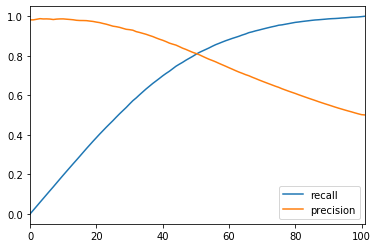

In [14]:
%matplotlib inline
lrmodel.stages[1].summary.pr.toPandas().plot()

In [15]:
print(lrmodel.stages[1].summary.areaUnderROC)
lrmodel.stages[1].summary.accuracy

0.8889226800457942


0.809393773894047

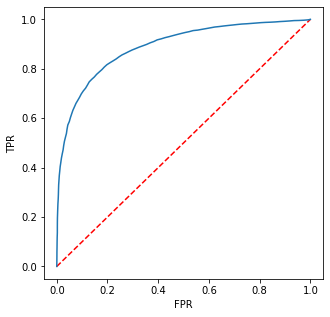

In [16]:
fpr = lrmodel.stages[1].summary.roc.select("FPR").collect()
tpr = lrmodel.stages[1].summary.roc.select("TPR").collect()
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

<li>https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#binary-classification</li>

<h1>Draw testing ROC</h1>
<li>The predictions contain two useful columns, the probability and the dependent value bucket</li>
<li>Extract these into a data frame</li>
<li>Note that the probability is expressed as a pair (probability of 0 and probability of 1)</li>
<li>Extract the probability of 1 from this (convert the df into an rdd, it will be easier!)</li>
<li>Also convert all values to float from Spark DoubleType (sklearn won't understand DoubleType)</li>

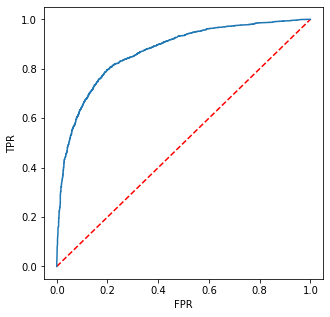

In [17]:
preds = rc_pred.select('DVBucket','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['DVBucket'])))\
    .collect()
from sklearn.metrics import roc_curve,auc,precision_recall_curve

y_score, y_true = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

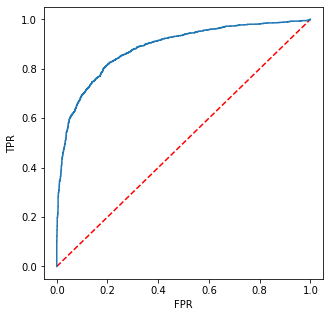

In [18]:
preds = lr_pred.select('DVBucket','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['DVBucket'])))\
    .collect()
from sklearn.metrics import roc_curve,auc,precision_recall_curve

y_score, y_true = zip(*preds)
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()